### Import Libraries

In [1]:
# ==============================
# 📦 Import Libraries
# ==============================
import os
import cv2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.layers import Add, Activation, Multiply
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import keras_tuner as kt

# Set random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### Load and Data Preprocessing 

In [12]:
def load_images(image_dir, mask_dir, image_size=(128, 128)):
    images, masks = [], []
    for filename in sorted(os.listdir(image_dir)):
        if not filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            continue
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # assumes same name pattern

        if not os.path.exists(mask_path):
            print(f"Mask missing for: {filename}")
            continue

        img = load_img(img_path, color_mode='grayscale', target_size=image_size)
        mask = load_img(mask_path, color_mode='grayscale', target_size=image_size)

        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    if masks.ndim == 3:
        masks = np.expand_dims(masks, axis=-1)
    return images, masks


base_path = "Train_Dataset_Generated"
image_dir = os.path.join(base_path, 'img')
mask_dir = os.path.join(base_path, 'mask')

images, masks = load_images(image_dir, mask_dir)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 160 images and 160 masks.


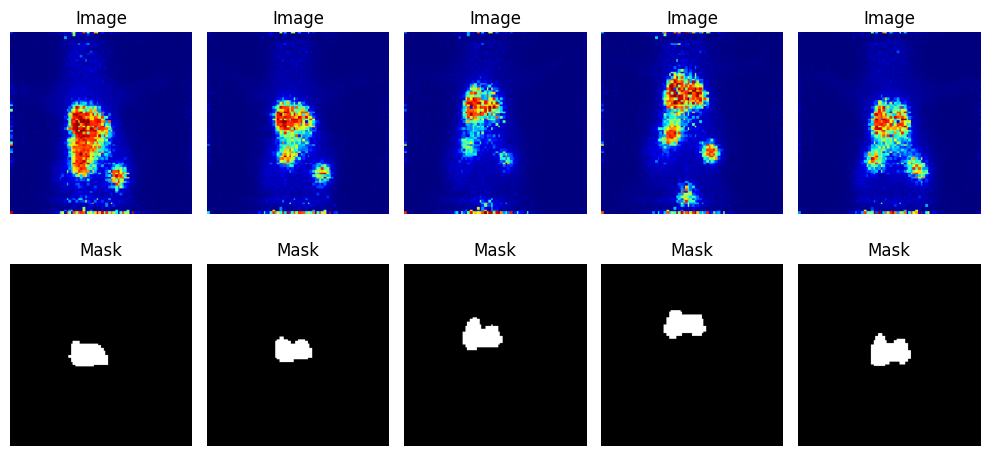

In [13]:
# Visualize some images and masks
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        if i >= len(images):
            break
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[6*i].squeeze(), cmap='jet')
        plt.axis('off')
        plt.title("Image")
        
        # Display mask
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(masks[6*i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Mask")
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks)

### Split Train/Test


In [15]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.2, random_state=42
)
print("Training:", X_train.shape, "Testing:", X_test.shape)

Training: (128, 128, 128, 1) Testing: (32, 128, 128, 1)


### Define Attention-U-Net Builder

In [5]:
def attention_gate(skip_connection, gating_signal, filters):
    """
    Attention Gate: Filters skip-connection using gating signal.
    skip_connection : Encoder feature map (long skip)
    gating_signal   : Decoder feature map (upsampled)
    filters         : Reduced intermediate channel size
    """
    theta_x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(skip_connection)
    phi_g   = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(gating_signal)

    # Combine encoder + decoder signals
    add = tf.keras.layers.Add()([theta_x, phi_g])
    act = Activation('relu')(add)

    # Attention coefficients
    psi = Conv2D(1, (1, 1), padding='same')(act)
    psi = Activation('sigmoid')(psi)

    # Multiply attention mask with skip connection
    attn_out = tf.keras.layers.Multiply()([skip_connection, psi])
    
    return attn_out

def build_attention_unet_tuner(hp):
    """
    Attention U-Net builder for KerasTuner
    hp: HyperParameters object from KerasTuner
    """
    input_shape = (128,128,1)
    
    # Define hyperparameters
    num_filters = hp.Choice("num_filters", values=[16, 32, 64])
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.1)
    learning_rate = hp.Choice("learning_rate", values=[1e-4, 1e-3, 1e-2])
    
    inputs = Input(input_shape)
    
    def encoder_block(inputs, num_filters, dropout_rate):
        x = Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
        return x

    def decoder_block(inputs, skip_connection, num_filters, dropout_rate):
        x = Conv2DTranspose(num_filters, 2, strides=2, padding='same')(inputs)
        attn_skip = attention_gate(skip_connection, x, num_filters)
        x = concatenate([x, attn_skip])
        x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
        return x

    # Encoder
    c1 = encoder_block(inputs, num_filters, dropout_rate)
    p1 = MaxPooling2D()(c1)
    c2 = encoder_block(p1, num_filters*2, dropout_rate)
    p2 = MaxPooling2D()(c2)
    c3 = encoder_block(p2, num_filters*4, dropout_rate*2)
    p3 = MaxPooling2D()(c3)
    c4 = encoder_block(p3, num_filters*8, dropout_rate*2)
    p4 = MaxPooling2D()(c4)
    c5 = encoder_block(p4, num_filters*16, dropout_rate*3)

    # Decoder
    u6 = decoder_block(c5, c4, num_filters*8, dropout_rate*2)
    u7 = decoder_block(u6, c3, num_filters*4, dropout_rate*2)
    u8 = decoder_block(u7, c2, num_filters*2, dropout_rate)
    u9 = decoder_block(u8, c1, num_filters, dropout_rate)

    outputs = Conv2D(1, 1, activation='sigmoid')(u9)
    
    model = Model(inputs, outputs)
    
    # Compile
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model


### Hyperparameter Tuning

In [6]:
tuner = kt.GridSearch(
    build_attention_unet_tuner,
    objective='val_loss',
    max_trials=5,
    directory='attention_unet_tuner_dir',
    project_name='attention_unet_gridsearch'
)

tuner.search_space_summary()

tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=3,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')]
)

tuner.results_summary()


Reloading Tuner from attention_unet_tuner_dir\attention_unet_gridsearch\tuner0.json
Search space summary
Default search space size: 3
num_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
Results summary
Results in attention_unet_tuner_dir\attention_unet_gridsearch
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.024329273030161858

Trial 4 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.042118996381759644

Trial 0 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.1
learning_rate: 0.0001
Score: 0.05886901542544365

Trial 2 summary
Hyperparameters:
nu

In [7]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"""
Best Hyperparameters:
num_filters = {best_hps.get('num_filters')}
dropout_rate = {best_hps.get('dropout_rate')}
learning_rate = {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
num_filters = 16
dropout_rate = 0.1
learning_rate = 0.001



In [11]:
model = build_attention_unet_tuner(best_hps)
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=4,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.9453 - loss: 0.4384 - val_accuracy: 0.9732 - val_loss: 0.1788
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.9741 - loss: 0.1070 - val_accuracy: 0.9732 - val_loss: 0.0470
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.9745 - loss: 0.0463 - val_accuracy: 0.9750 - val_loss: 0.0437
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.9811 - loss: 0.0413 - val_accuracy: 0.9831 - val_loss: 0.0397
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.9854 - loss: 0.0349 - val_accuracy: 0.9846 - val_loss: 0.0339
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - accuracy: 0.9864 - loss: 0.0320 - val_accuracy: 0.9879 - val_loss: 0.0290
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 350ms/step - accuracy: 0.9872 - loss: 0.0308 - val_accuracy: 0.9881 - val_loss: 0.0281
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.9870 - loss: 0.0308 - val_accuracy:

In [56]:
model.save('model_2_attention-Unet.h5')

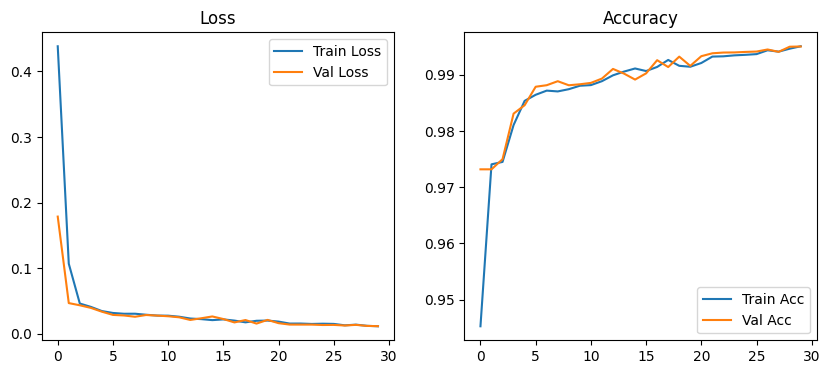

In [12]:
# -------------------------------
# Plot Training Curves
# -------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()


In [17]:
from tensorflow.keras.models import load_model

model = load_model('z_models/model_5_attention-Unet.h5', compile=False)


In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

preds_test = model.predict(X_test)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

dice_scores = []
precisions = []
recalls = []
accuracies = []

TP_total = 0
TN_total = 0
FP_total = 0
FN_total = 0

for i in range(len(X_test)):
    y_true = y_test[i].squeeze()
    y_pred = preds_test_t[i].squeeze()
    
    # Flatten for sklearn metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    dice_scores.append(dice_coef(y_true, y_pred))
    precisions.append(precision_score(y_true_flat, y_pred_flat))
    recalls.append(recall_score(y_true_flat, y_pred_flat))
    accuracies.append(accuracy_score(y_true_flat, y_pred_flat))
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1]).ravel()
    TP_total += tp
    TN_total += tn
    FP_total += fp
    FN_total += fn

print(f"Average Dice Coefficient: {np.mean(dice_scores):.3f}")
print(f"Average Precision: {np.mean(precisions):.3f}")
print(f"Average Recall: {np.mean(recalls):.3f}")
print(f"Average Accuracy: {np.mean(accuracies):.3f}")

print("\nTotal Confusion Matrix:")
print(f"TP: {TP_total}, TN: {TN_total}, FP: {FP_total}, FN: {FN_total}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
Average Dice Coefficient: 0.816
Average Precision: 0.863
Average Recall: 0.798
Average Accuracy: 0.992

Total Confusion Matrix:
TP: 11039, TN: 509108, FP: 1508, FN: 2633


c:\Users\Abraham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


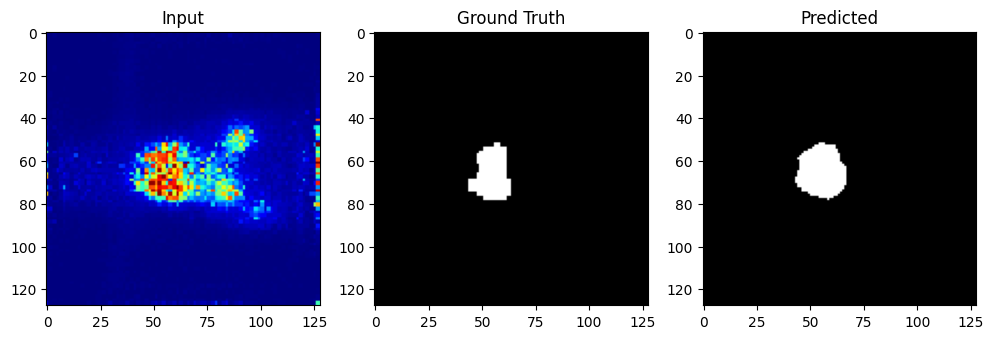

In [11]:
# -------------------------------
# Visualize a Random Prediction
# -------------------------------
import random
ix = random.randint(0, len(X_test) - 1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(X_test[ix].squeeze(), cmap='jet'); plt.title('Input')
plt.subplot(1,3,2); plt.imshow(y_test[ix].squeeze(), cmap='gray'); plt.title('Ground Truth')
plt.subplot(1,3,3); plt.imshow(preds_test_t[ix].squeeze(), cmap='gray'); plt.title('Predicted')
plt.show()